# Вебинар 6. Двухуровневые модели рекомендаций


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [5]:
recommender.get_als_recommendations(296, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [6]:
recommender.get_own_recommendations(296, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [7]:
recommender.get_similar_items_recommendation(2499, N=5)

[901062, 5569845, 907631, 9364612, 12301109]

In [8]:
recommender.get_similar_users_recommendation(2499, N=5)

[1053329, 10285454, 893362, 916990, 988277]

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
# Различные варианты генерации кандидатов.

N=50
# res = result_lvl_1.copy()

funcs = {'als_recommendations': recommender.get_als_recommendations,
       'own_recommendations': recommender.get_own_recommendations,
       'similar_items_recommendation': recommender.get_similar_items_recommendation,
       'similar_users_recommendation': recommender.get_similar_users_recommendation}

for key, func in funcs.items():
    result_lvl_1[key] = result_lvl_1['user_id'].apply(lambda x: func(x, N=N))
    result_lvl_1['recall-'+key] = result_lvl_1['user_id'].apply(lambda x: recall_at_k(list(result_lvl_1.loc[result_lvl_1['user_id']==x, key])[0],\
                                                          list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'actual'])[0], k=N))    

In [11]:
for key, func in funcs.items():
    print(f"генерация при помощи - {key}, recall = {result_lvl_1['recall-'+ key].mean()}" )

генерация при помощи - als_recommendations, recall = 0.047630975420893194
генерация при помощи - own_recommendations, recall = 0.06519221251051327
генерация при помощи - similar_items_recommendation, recall = 0.03468389125937804
генерация при помощи - similar_users_recommendation, recall = 0.002805234836922033


In [12]:
# Зависимость recall@k от k.

rc = []
k =  [20, 50, 100, 200, 500]
key = 'own_recommendations'
func = recommender.get_own_recommendations
res = result_lvl_1.copy()
for num_recommend in k:
    result_lvl_1[key] = result_lvl_1['user_id'].apply(lambda x: func(x, N=num_recommend))
    result_lvl_1['recall'+key] = result_lvl_1['user_id'].apply(lambda x: recall_at_k(list(result_lvl_1.loc[result_lvl_1['user_id']==x, key])[0],\
                                                          list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'actual'])[0], k=num_recommend))
    rc.append(result_lvl_1['recall'+ key].mean()) 

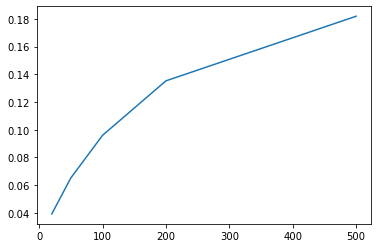

In [13]:
plt.plot(k, rc);

In [14]:
%%time
s = recommender.get_als_recommendations(1, N=5)

Wall time: 16 ms


In [15]:
%%time
a = recommender.get_als_recommendations(1, N=500)

Wall time: 24 ms


Скорость выдачи рекоммендаций при разных N не зависит от времени, поэтому при выборе N необходимо руководствоваться характеристиками второго уровня. В силу того что из N рекоммендаций первого уровня, модель второго уровня должна выбрать 5, количество N должно обеспечить возможность выбора 5 итоговых рекоммендаций. Если N будет слишком мала мы получим по 1-2 итоговых рекомендаций, это заставит нас дополнять недостающие популярными, что снизит метрики. Если же N будет слишком большая и мы получим больше рекомендаций чем требуется, не рационально используем ресурс. 

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?
    
    
Далее оценить на валидационном множестве precision    
    

In [16]:
class Preprocessing():
    
    def __init__(self, model, N=50):
        self.model = model
        self.N = N     
    
    def new_features_user(self, data_train_lvl_2, item_features):
        '''определяет новые фичи покупателя
        1. средняя сумма покупки покупателем товара в категории
        2. количество покупак товара в категории
        3. средний чек покупателя
        4. общее число покупок
        '''
        data = data_train_lvl_2.merge(item_features, on='item_id', how='left')
        new_f_1 = data.groupby(['user_id', 'department'])['sales_value'].agg(['mean','count']).reset_index()
        new_f_2 = data.groupby(['user_id'])['sales_value'].agg(['mean','count']).reset_index()
        new_f_u = new_f_1.merge(new_f_2, on= 'user_id', how='left')
        new_f_u.columns = ['user_id', 'department', 'mean_department', 'count_department','mean_all','count_al']
        return new_f_u
    
    def new_features_item(self, data_train_lvl_2, item_features):
        '''определяет новые фичи товара
        1. Среднее количество товара проданного за неделю
        2. Среднее количество товара в категории проданного за неделю
        3. Отношение количества товара к количеству товара в категории проданных за неделю
        '''
        data = data_train_lvl_2.merge(item_features, on='item_id', how='left')
        new_f_1 = data.groupby(['item_id'])['quantity'].sum().reset_index()
        num_week = data['week_no'].max()- data['week_no'].min()
        new_f_1['quantity'] = new_f_1['quantity'].apply(lambda x: x/num_week)
        new_f_1.columns = ['item_id', 'quantity_per_week']
        new_f_1 = new_f_1.merge(data[['item_id','department'] ], on= 'item_id', how='left')        
        
        depar = data.groupby(['department'])['quantity'].sum().reset_index()
        depar['quantity'] = depar['quantity'].apply(lambda x: x/num_week)
        depar.columns = ['department', 'quantity_depar']
        new_f_i = new_f_1.merge(depar, on='department', how='left')
        new_f_i['one_quantyti_per_all_quantyti'] = new_f_i['quantity_per_week']/new_f_i['quantity_depar']
        new_f_i.drop('department', inplace=True, axis=1)      
        return new_f_i
    
    
    def fit_transform(self, data_train_lvl_2, item_features, user_features):       
        self.item_features = item_features
        self.user_features = user_features
        
        self.new_f_u = self.new_features_user(data_train_lvl_2, item_features)
        self.new_f_i = self.new_features_item(data_train_lvl_2, item_features)        
        
        users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
        users_lvl_2.columns = ['user_id']
        self.train_users = data_train_lvl_1['user_id'].unique()
        users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(self.train_users)]
        users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: self.model.get_own_recommendations(x, N=self.N))

        s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
        s.name = 'item_id'
        users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
        users_lvl_2['flag'] = 1        

        targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
        targets_lvl_2['target'] = 1 
        targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
        targets_lvl_2['target'].fillna(0, inplace= True)
        targets_lvl_2.drop('flag', axis=1, inplace=True)        
        
        targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
        targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

        targets_lvl_2 = targets_lvl_2.merge(self.new_f_u, on= ['user_id', 'department'], how='left')     
        targets_lvl_2 = targets_lvl_2.merge(self.new_f_i, on= 'item_id', how='left')             
      
        X_train = targets_lvl_2.drop('target', axis=1)
        y_train = targets_lvl_2[['target']]
        
        self.cat_feats = X_train.columns[2:15].tolist()
        X_train[self.cat_feats] = X_train[self.cat_feats].astype('category')
        return X_train, y_train
        

    def transform(self, data_val_lvl_2):          
        users_lvl_2 = pd.DataFrame(data_val_lvl_2['user_id'].unique())
        users_lvl_2.columns = ['user_id']
        users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(self.train_users)]
        users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: self.model.get_own_recommendations(x, N=self.N))        

        s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
        s.name = 'item_id'
        users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
        users_lvl_2['flag'] = 1          
        
        targets_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
        targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
        
        targets_lvl_2.drop('flag', axis=1, inplace=True)
        targets_lvl_2 = targets_lvl_2.merge(self.item_features, on='item_id', how='left')
        targets_lvl_2 = targets_lvl_2.merge(self.user_features, on='user_id', how='left')
        targets_lvl_2 = targets_lvl_2.merge(self.new_f_u, on= ['user_id', 'department'], how='left')           
        targets_lvl_2 = targets_lvl_2.merge(self.new_f_i, on= 'item_id', how='left')        
        
        X_train = targets_lvl_2
        X_train[self.cat_feats] = X_train[self.cat_feats].astype('category')
        return X_train
        
        
        
    def fit(self, X_train, y_train):
        self.lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=self.cat_feats, random_state=42)
        self.lgb.fit(X_train, y_train)
        
    def predict(self, X_train):
        train_preds = self.lgb.predict(X_train)
        return train_preds
    
    def predict_user_list(self, X_train, extend=True):
        '''
        extend=True - дополняент рекоммендации по N=5 используя популярные товары
        '''
        train_preds = self.lgb.predict(X_train)
        res = X_train.copy()     
        res['predict'] = train_preds
        res = res.loc[res['predict']==1]
        res = res.groupby('user_id')['item_id'].agg(set).reset_index()
        res['pred_item'] = res['item_id'].apply(lambda x: list(x))
        res.drop('item_id', inplace=True, axis=1)        
        if extend:
            res['pred_item'] = res['pred_item'].apply(lambda x: self.model._extend_with_top_popular(x, N=5))
        return res      
        
        
        

In [17]:
model = Preprocessing(recommender)
X_train, y_train = model.fit_transform(data_train_lvl_2, item_features, user_features)
model.fit(X_train, y_train)
X_train.shape

C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


(3972650, 22)

In [18]:
X_val = model.transform(data_val_lvl_2)
X_val.shape
# model.predict(X)

(3533692, 22)

In [19]:
pred = model.predict_user_list(X_val, extend=False)
train = model.predict_user_list(X_train, extend=False)
print(X_val.shape, X_train.shape)

pred_ex = model.predict_user_list(X_val, extend=True)
train_ex = model.predict_user_list(X_train, extend=True)

train.columns = ['user_id','train_item']
train_ex.columns = ['user_id','train_ex_item']
pred_ex.columns =  ['user_id','pred_ex_item']

(3533692, 22) (3972650, 22)


In [20]:
result_lvl_1 = result_lvl_1.merge(pred, on='user_id')
result_lvl_1 = result_lvl_1.merge(train, on='user_id')
result_lvl_1 = result_lvl_1.merge(pred_ex, on='user_id')
result_lvl_1 = result_lvl_1.merge(train_ex, on='user_id')

In [21]:
re = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
re.columns=['user_id', 'actual_v2']
result_lvl_1 = result_lvl_1.merge(re, on='user_id')

In [22]:
result_lvl_1['precision_pred'] = result_lvl_1['user_id'].apply(lambda x: precision_at_k(list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'pred_item'])[0],\
                                                          list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'actual_v2'])[0], k=N))    

In [23]:
result_lvl_1['precision_train'] = result_lvl_1['user_id'].apply(lambda x: precision_at_k(list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'train_item'])[0],\
                                                          list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'actual'])[0], k=N))   

In [24]:
result_lvl_1['precision_ex_pred'] = result_lvl_1['user_id'].apply(lambda x: precision_at_k(list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'pred_ex_item'])[0],\
                                                          list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'actual_v2'])[0], k=N)) 

In [25]:
result_lvl_1['precision_ex_train'] = result_lvl_1['user_id'].apply(lambda x: precision_at_k(list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'train_ex_item'])[0],\
                                                          list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'actual'])[0], k=N)) 

In [26]:
result_lvl_1['precision_own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: precision_at_k(list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'own_recommendations'])[0],\
                                                          list(result_lvl_1.loc[result_lvl_1['user_id']==x, 'actual'])[0], k=N))   

In [27]:
 print(f"Precision на валидационной выборке: {result_lvl_1['precision_pred'].mean()}")  

Precision на валидационной выборке: 0.38857531532942413


In [28]:
 print(f"Precision на валидационной выборке при условии дополнения рекоммендаций до N=5\n",
       f"(из категории популярные товары): {result_lvl_1['precision_ex_pred'].mean()}")

Precision на валидационной выборке при условии дополнения рекоммендаций до N=5
 (из категории популярные товары): 0.26982268153254185


In [29]:
 print(f"Precision на обучающей выборке: {result_lvl_1['precision_train'].mean()}")  

Precision на обучающей выборке: 0.7660424910108852


In [30]:
 print(f"Precision на обучающей выборке при условии дополнения рекоммендаций до N=5\n",
       f"(из категории популярные товары): {result_lvl_1['precision_ex_train'].mean()}")

Precision на обучающей выборке при условии дополнения рекоммендаций до N=5
 (из категории популярные товары): 0.47008800302099746


In [31]:
 print(f"Precision на первой модели при генерации при помощи own_recommendations: {result_lvl_1['precision_own_recommendations'].mean()}")  

Precision на первой модели при генерации при помощи own_recommendations: 0.13552465233881186
